# Data Management and Visualization

## Importing libraries and reading Dataset

In [1]:
# DMV imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print('reading csv')
data = pd.read_csv(
    'source/NESARC Dataset.csv'
)

reading csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18876\2125044456.py:2: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


## Data Management

Try toggling the next cell's comment

In [3]:
NESARC_columns = [
    'S7Q1', 'S7Q10', 'S7Q17C', 'S7Q21', 'S7Q26', 'S7Q27', 
    'S7Q29', 'S7Q31A', 'S11BQ1', 'S11BQ2', 'S11BQ3C', 'S11BQ4C',
    'S11BQ5C', 'S11BQ6C', 'S11BQ7C', 'S11BQ8C', 'S11BQ9C', 'S11BQ10C', 
    'S11BQ11', 'S11BQ12', 'S11BQ13', 'S11BQ14', 'SEX'
]

sub1 = data[NESARC_columns]#.apply(pd.to_numeric, errors='coerce')

In [4]:
#Create a copy of the dataframe
sub2 = sub1.copy()

In [5]:
# Creating a new list of columns, only referring to SAD
columns_SAD = [
    'S7Q1', 'S7Q10', 'S7Q17C', 'S7Q21', 
    'S7Q26', 'S7Q27','S7Q29', 'S7Q31A'
]

In [6]:
# Replace unknown values with NaN and enforce numeric type
for col in columns_SAD:
    if col != 'S7Q1' and col != 'S7Q17C' and col != 'SEX':
        sub2[col] = sub2[col].replace(9, pd.NA)
    if col == 'S7Q17C':
        sub2[col] = sub2[col].replace(99, pd.NA)

    # Enforce numeric dtype after replacements
    sub2[col] = pd.to_numeric(sub2[col], errors='coerce')


In [7]:


# Apply the filter for observations I'll work with
sub2 = sub2[
    (sub2['S7Q1'] == 1) |
      ((sub2['S7Q1'] == 9) & (sub2[columns_SAD] == 1).any(axis=1))
]

In [8]:
def process_S7Q17C(row_value):
    if pd.notna(row_value):
        # Agrupar los valores
        if row_value == 0:
            group = 0
            label = '0 episodes'
        elif 1 <= row_value <= 5:
            group = 1
            label = '1-5 episodes'
        elif 5 < row_value <= 20:
            group = 2
            label = '6-20 episodes'
        elif 20 < row_value <= 50:
            group = 3
            label = '21-50 episodes'
        elif row_value > 50:
            group = 4
            label = 'More than 50 episodes'
    else:
        group = 0
        label = '0 episodes'

    return pd.Series([group, label], index=['S7Q17C_grouping', 'S7Q17C_classifying'])

# Aplicar la función y generar ambas columnas al mismo tiempo
sub2[['S7Q17C_grouping', 'S7Q17C_classifying']] = sub2['S7Q17C'].apply(process_S7Q17C)


In [9]:
# Assign points based on the SAD scoring system
def calculate_points(row):
    # Define a dictionary with column names as keys and
    #  their associated points as values
    point_mapping = {
        'S7Q1': 1,
        'S7Q10': 0.5,
        'S7Q21': 1,
        'S7Q26': 1.5,
        'S7Q27': 2,
        'S7Q29': 1
    }
    
    # Initialize points
    points = 0
    
    # Iterate over the dictionary and calculate the total points
    for column, point_value in point_mapping.items():
        if not pd.isna(row[column]) and row[column] == 1:
            points += point_value
    
    # Handle S7Q17C_grouping based on the new classification
    if not pd.isna(row['S7Q17C_grouping']):
        if row['S7Q17C_grouping'] == 0:
            points += 0
        elif row['S7Q17C_grouping'] == 1:
            points += 1
        elif row['S7Q17C_grouping'] == 2:
            points += 2
        elif row['S7Q17C_grouping'] == 3:
            points += 3
        elif row['S7Q17C_grouping'] == 4:
            points += 4
    
    return points

# Apply the function
sub2['SAD_score'] = sub2.apply(lambda row: calculate_points(row), axis=1)


In [10]:
# Classify into the SAD spectrum
def classify_spectrum(points):
    if pd.notna(points):  # Check if points is not NaN
        if points <= 2:
            return 'Low Spectrum'
        elif 2 < points <= 5:
            return 'Medium Spectrum'
        else:
            return 'High Spectrum'
    return 'Unknown'  # Return 'Unknown' if points is NaN

# Create the SAD_spectrum column
sub2['SAD_spectrum'] = sub2['SAD_score'].apply(classify_spectrum)

In [11]:
#Create a list of columns for Family behavioral history
columns_fam_history = [
    'S11BQ1', 'S11BQ2', 'S11BQ3C', 'S11BQ4C', 'S11BQ5C', 
    'S11BQ6C', 'S11BQ7C', 'S11BQ8C', 'S11BQ9C', 'S11BQ10C', 
    'S11BQ11', 'S11BQ12', 'S11BQ13', 'S11BQ14'
]

#Replace 9s with NaN
sub2 [columns_fam_history] = sub2[
    columns_fam_history].replace(9,pd.NA)

#Sum the amount of first degree relatives with history of behaivoral problems
behavior_problems_count = (
    sub2[columns_fam_history] == 1).sum(axis=1)


#Create a columns for behavior_problems_count
sub2['behavior_problems_count'] = behavior_problems_count

In [12]:
#Create a list with all the research variables, including the new ones
NESARC_research_variables = sub2.columns.tolist()

#Now, create a list with just the new variables
analysis_variables = [
    'SAD_score', 
    'SAD_spectrum',
    'behavior_problems_count',
    'S7Q17C_grouping',
    'S7Q17C_classifying'
      ]

#Create a dictionary to store the frequencies of the study variables
freq_results = {}  # A dictionary to hold results for each variable

for col in NESARC_research_variables:
    abs_freq = sub2.groupby(col).size()
    rel_freq = sub2.groupby(col).size() * 100 / len(sub2)
    
    # Store results in the freq_results dictionary
    freq_results[col] = {
        'absolute': abs_freq,
        'relative': rel_freq
    }

# # Format frequencies for printing for the selected variables
# for var in analysis_variables:
#     if var in freq_results:  # Check if the variable exists in the dictionary
#         print(f"\nFrequencies for {var}:")
#         for freq_type, freq_values in freq_results[var].items():
#             print(f"{freq_type.capitalize()} frequencies:\n{freq_values}\n")
            

In [13]:
#Creating relations between variables
spec_behavior_problems = sub2.groupby(
    'SAD_spectrum')['behavior_problems_count'].mean()

spec_episode_count = sub2.groupby(
    'SAD_spectrum')['S7Q17C'].mean()

spec_symptoms_filtered = (
    sub2[columns_SAD].map(
        lambda x: 1 if pd.notna(x) and x == 1 else 0
        )
    )
spec_symptoms = (
    spec_symptoms_filtered.groupby(sub2['SAD_spectrum']).sum()
)

# Apply the same logic to behavior_problems_count and add the SAD_spectrum count
spec_behavior_problems_correlation = sub2.groupby('SAD_spectrum').agg(
    behavior_problems_sum=('behavior_problems_count', lambda x: (x == 1).sum()),  # Sum of relatives with behavioral problems
    SAD_spectrum_count=('behavior_problems_count', 'size')  # Count of people in each SAD_spectrum
)


In [14]:
#Creating a new DataFrame to analyze the grouped variables
# Store all the results in a dictionary
results = {
    'spec_symptoms': spec_symptoms,
    'spec_behavior_problems': spec_behavior_problems,
    'spec_episode_count': spec_episode_count,
    'spec_behavior_problems_correlation': spec_behavior_problems_correlation
}

# Rename columns to avoid overlapping names
column_names_corr = {
    'spec_symptoms': ['S7Q1_symptom_count','S7Q10_symptom_count', 
                      'S7Q17C_symptom_count', 'S7Q21_symptom_count',
                      'S7Q26_symptom_count', 'S7Q27_symptom_count', 
                      'S7Q29_symptom_count', 'S7Q31A_symptom_count'],
    'spec_behavior_problems': ['behavioral_problems_avg'],
    'spec_episode_count': ['episode_count_avg'],
    'spec_behavior_problems_correlation': ['behavioral_problems_count', 'SAD_spectrum_count']
}

# Function to convert and rename columns
def convert_to_dataframe(result_name, data):
    df = pd.DataFrame(data)  # Convert to DataFrame
    df.columns = column_names_corr[result_name]  # Rename columns
    return df

# Apply the function to all variables
results = {name: convert_to_dataframe(name, data) for name, data in results.items()}

#Join the df's in a single one
correlation_df = pd.concat(
    results.values(), axis=1
)

## Graphing

In [15]:
#Create a list to store all graphs
figures = []

### Univariate graphs

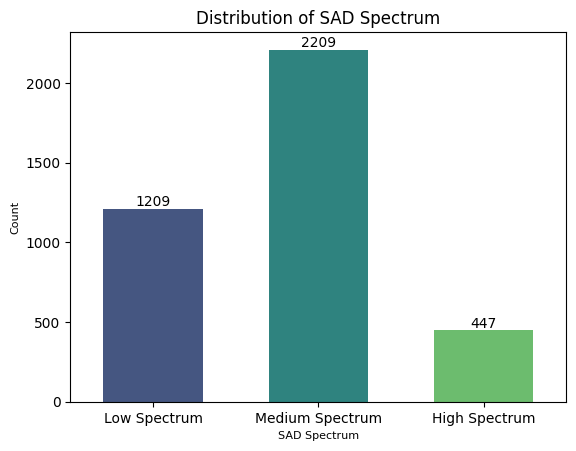

In [16]:
#SAD_spectrum countplot
countplot_SAD_spectrum = sns.countplot(
    data=sub2, 
    x='SAD_spectrum', 
    hue= 'SAD_spectrum',
    palette='viridis', 
    width=0.6,
    )

#Add count labels
for container in countplot_SAD_spectrum.containers:
    countplot_SAD_spectrum.bar_label(container, fontsize=10, color='black')

#Formatting
plt.title('Distribution of SAD Spectrum', fontsize=12)
plt.xlabel('SAD Spectrum', fontsize=8)
plt.ylabel('Count', fontsize=8)
figures.append(plt.gcf())
plt.show()

In [17]:
sub2['SAD_score'].describe()

count    3865.000000
mean        3.235576
std         1.504114
min         1.000000
25%         2.000000
50%         2.500000
75%         4.500000
max        11.000000
Name: SAD_score, dtype: float64

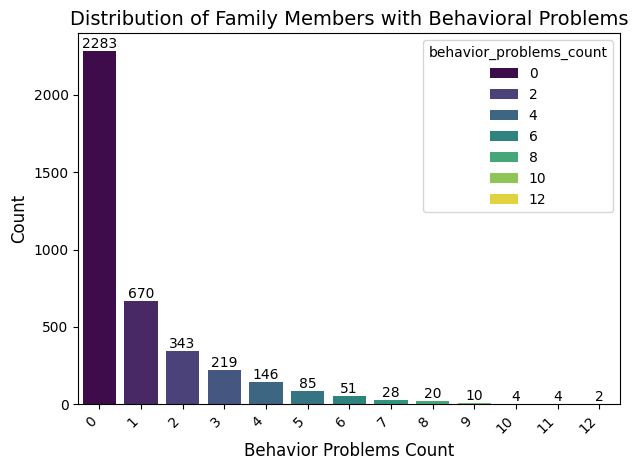

In [18]:
#behavior_problems_count countplot
countplot_behavior_problems_count = sns.countplot(
    data=sub2, 
    x='behavior_problems_count', 
    hue= 'behavior_problems_count',
    palette='viridis', 
    order=sorted(sub2['behavior_problems_count'].dropna().unique())
)

for container in countplot_behavior_problems_count.containers:
    countplot_behavior_problems_count.bar_label(container, fontsize=10, color='black')
plt.title('Distribution of Family Members with Behavioral Problems', fontsize=14)
plt.xlabel('Behavior Problems Count', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for clarity
plt.tight_layout()
figures.append(plt.gcf())
plt.show()

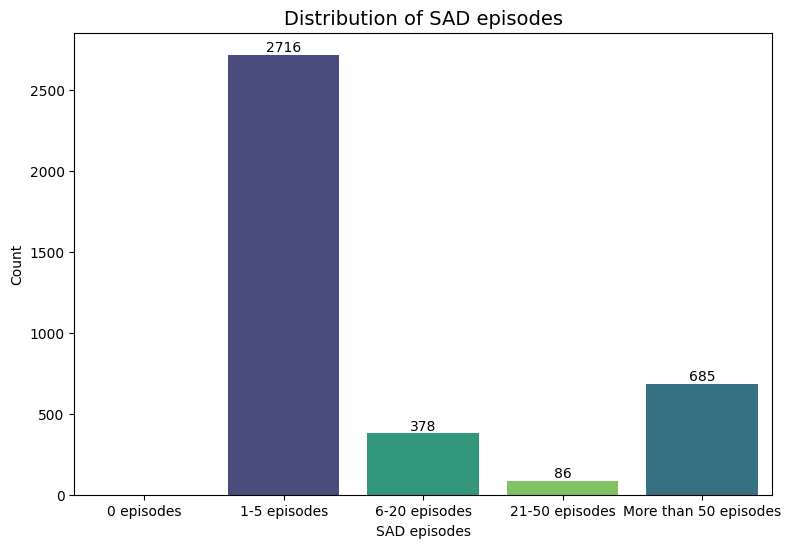

In [19]:
#S7Q17C_classifying countplot
plt.figure(figsize=(9, 6))
countplot_S7Q17C_classifying = sns.countplot(
    data=sub2, 
    x='S7Q17C_classifying', 
    hue= 'S7Q17C_classifying',
    palette='viridis', 
    legend=False,
    order= ['0 episodes', '1-5 episodes', '6-20 episodes', 
            '21-50 episodes', 'More than 50 episodes']
)
#Add count labels
for container in countplot_S7Q17C_classifying.containers:
    countplot_S7Q17C_classifying.bar_label(container, fontsize=10, color='black')
plt.title('Distribution of SAD episodes', fontsize=14)
plt.xlabel('SAD episodes', fontsize=10)
plt.ylabel('Count', fontsize=10)
figures.append(plt.gcf())
plt.show()

### Bivariate graphs

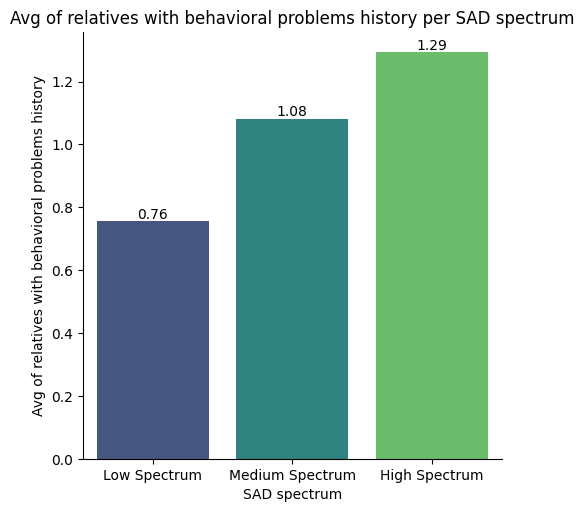

In [20]:
#SAD_spectrum and behavior_problems_count catplot
catplopt_SAD_spec_beh = sns.catplot(
        x='SAD_spectrum',
        y='behavior_problems_count',
        data=sub2,
        kind = 'bar',
        hue= 'SAD_spectrum',
        palette= 'viridis',
        errorbar=None
    )

for p in catplopt_SAD_spec_beh.ax.patches:
    catplopt_SAD_spec_beh.ax.annotate(
        f'{p.get_height():.2f}',  # Value of the bar
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Positioning the text on top of the bar
        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points'
    )
plt.xlabel('SAD spectrum')
plt.ylabel('Avg of relatives with behavioral problems history')
plt.title('Avg of relatives with behavioral problems history per SAD spectrum')
figures.append(plt.gcf())
plt.show()

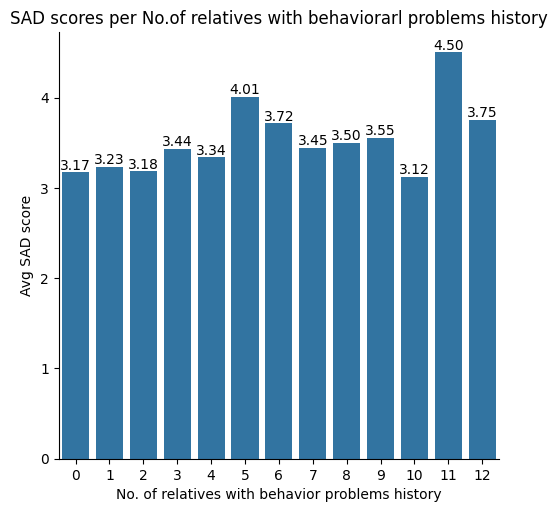

In [21]:
#behavior_problems_count and SAD_score catplot
catplot_beh_SAD_score = sns.catplot(
        x='behavior_problems_count', 
        y='SAD_score', 
        data=sub2, 
        kind = 'bar', 
        errorbar=None)
for p in catplot_beh_SAD_score.ax.patches:
    catplot_beh_SAD_score.ax.annotate(
        f'{p.get_height():.2f}',  # Value of the bar
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Positioning the text on top of the bar
        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points'
    )
plt.ylabel('Avg SAD score')
plt.xlabel('No. of relatives with behavior problems history')
plt.title('SAD scores per No.of relatives with behaviorarl problems history')
figures.append(plt.gcf())
plt.show()

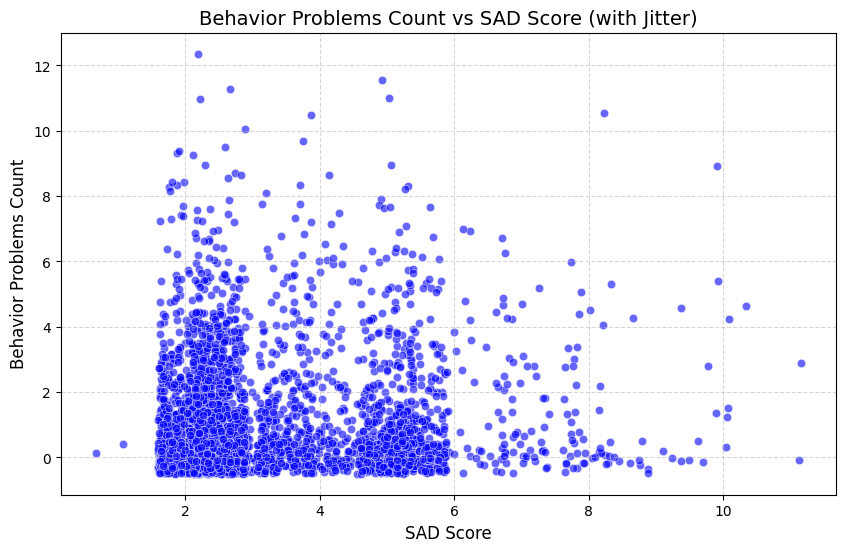

In [22]:
#SAD_score and behavior_problems_count scatter plot with jitter
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=sub2['SAD_score'] + np.random.uniform(-0.4, 0.4, size=sub2.shape[0]),  # Add jitter to SAD_score
    y=sub2['behavior_problems_count'] + np.random.uniform(-0.5, 0.5, size=sub2.shape[0]),  # Add jitter to behavior_problems_count
    alpha=0.6, color='blue'
)
plt.title('Behavior Problems Count vs SAD Score (with Jitter)', fontsize=14)
plt.xlabel('SAD Score', fontsize=12)
plt.ylabel('Behavior Problems Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
figures.append(plt.gcf())
plt.show()

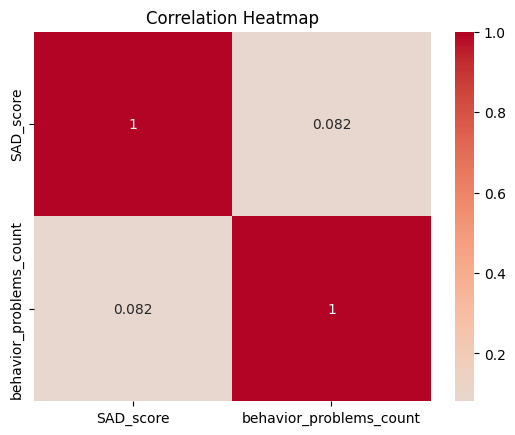

In [23]:
# Calculate the Pearson correlation coefficient
correlation_research_question = sub2[
    ['SAD_score', 'behavior_problems_count']
    ].corr(method='pearson')
sns.heatmap(correlation_research_question, 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title('Correlation Heatmap')
figures.append(plt.gcf())
plt.show()

### Complementary analysis

In [24]:
symptom_columns = ['S7Q1', 'S7Q10', 'S7Q21', 'S7Q26', 'S7Q27', 'S7Q29', 'S7Q31A']
proportion_symptoms = sub2[symptom_columns].apply(lambda x: (x == 1).mean())  # Proportion of 'yes' answers

# Calculate proportions of symptoms within each SAD spectrum
symptom_by_spectrum = sub2.groupby('SAD_spectrum')[symptom_columns].apply(lambda x: (x == 1).mean())


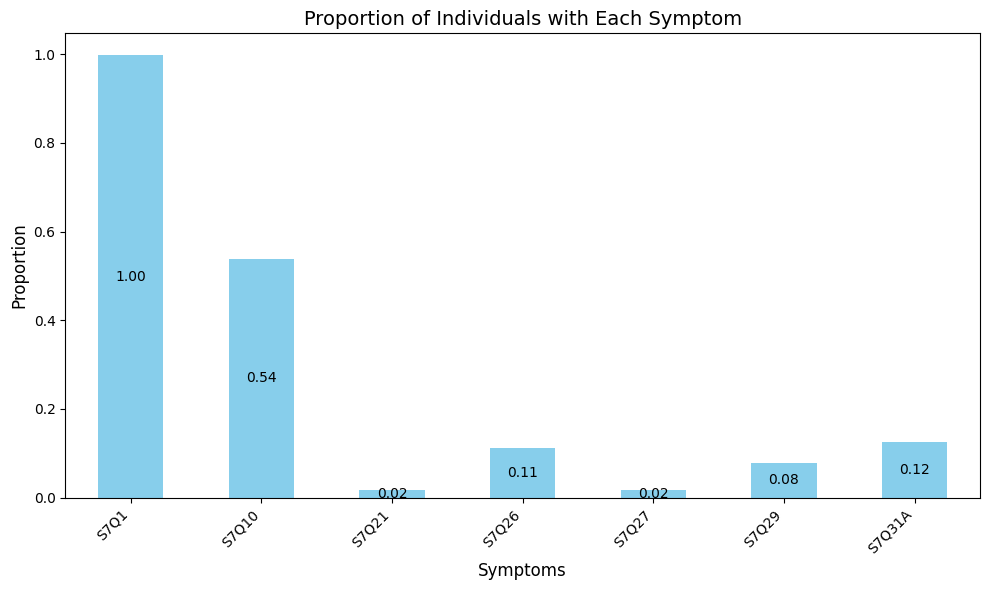

In [25]:
#Create proportion_symptoms_plot plot
proportion_symptoms_plot= proportion_symptoms.plot(
    kind='bar', 
    figsize=(10, 6), 
    color='skyblue')
for p in proportion_symptoms_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get the position of each rectangle (bar)
    proportion_symptoms_plot.annotate(f'{height:.2f}', (x + width / 2, y + height / 2), ha='center', va='center', color='black')


plt.title('Proportion of Individuals with Each Symptom', fontsize=14)
plt.ylabel('Proportion', fontsize=12)
plt.xlabel('Symptoms', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
figures.append(plt.gcf())
plt.show()

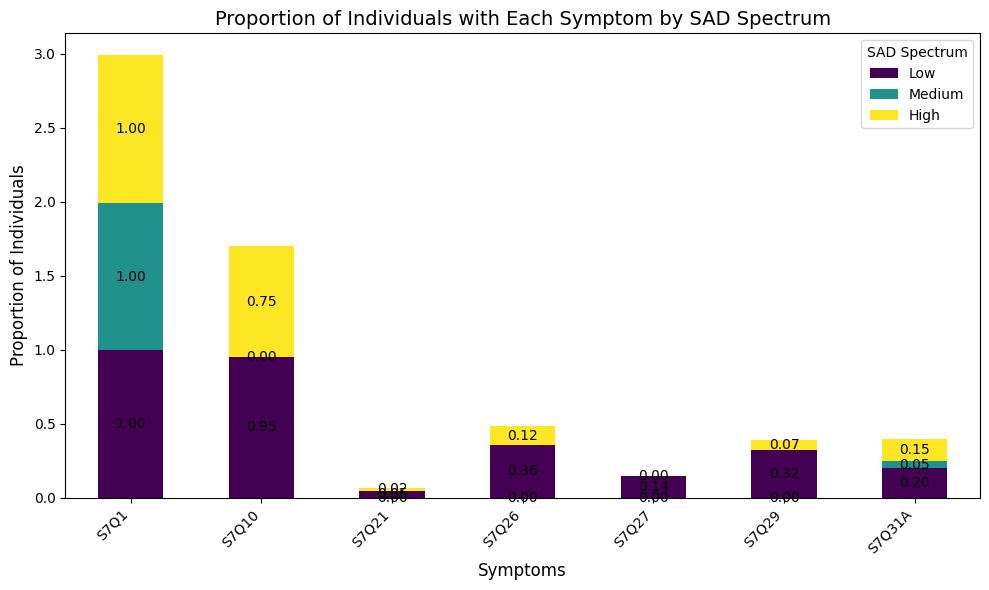

In [26]:
#Create symptom_by_spectrum_plot plot
symptom_by_spectrum = symptom_by_spectrum.T  # Transpose for easier visualization
symptom_by_spectrum_plot = symptom_by_spectrum.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    colormap='viridis')

# Add labels inside each bar
for p in symptom_by_spectrum_plot.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get the position of each rectangle (bar)
    symptom_by_spectrum_plot.annotate(
        f'{height:.2f}', 
        (x + width / 2, y + height / 2), 
        ha='center', 
        va='center', 
        color='black')

plt.title('Proportion of Individuals with Each Symptom by SAD Spectrum', fontsize=14)
plt.ylabel('Proportion of Individuals', fontsize=12)
plt.xlabel('Symptoms', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='SAD Spectrum', labels=['Low', 'Medium', 'High'])
plt.tight_layout()
figures.append(plt.gcf())
plt.show()

# Data Analysis Tools

## Importing new libraries

In [27]:
# DAT imports
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

## ANOVA Testing

Gathering the new research variables

In [28]:
# Create dat_df with the variables of interest
anova_df = sub2[['SAD_spectrum', 'behavior_problems_count']].copy()

# Checking for mean differences
anova_df.groupby('SAD_spectrum')['behavior_problems_count'].mean().sort_values()

SAD_spectrum
Low Spectrum       0.755170
Medium Spectrum    1.082390
High Spectrum      1.293065
Name: behavior_problems_count, dtype: float64

ANOVA testing

In [29]:
# ANOVA model
anova_model = smf.ols('behavior_problems_count ~ C(SAD_spectrum)', data=anova_df).fit()
sm.stats.anova_lm(anova_model, typ=2)
# anova_model.summary()


,sum_sq,df,F,PR(>F)
C(SAD_spectrum),125.781555,2.0,22.243886,2.482106e-10
Residual,10919.143671,3862.0,NaN,NaN


Post Hoc Test

In [30]:
# Tukey's HSD Post Hoc Test
tukey = multi.pairwise_tukeyhsd(anova_df['behavior_problems_count'], anova_df['SAD_spectrum'])
print(tukey)


        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
High Spectrum    Low Spectrum  -0.5379    0.0 -0.7561 -0.3197   True
High Spectrum Medium Spectrum  -0.2107 0.0417 -0.4151 -0.0062   True
 Low Spectrum Medium Spectrum   0.3272    0.0  0.1862  0.4683   True
--------------------------------------------------------------------


## Chi-Square (χ2) Test 

In [31]:
# Create a new column to indicate if the individual 
# has relatives with behavioral problems
anova_df['relatives_with_problems'] = anova_df['behavior_problems_count'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Create a new DataFrame for the chi-square test
x2_df = anova_df[['SAD_spectrum', 'relatives_with_problems']].copy()

In [32]:
# Checking for absolute differences
x2_contingency = pd.crosstab(x2_df['SAD_spectrum'], x2_df['relatives_with_problems'])
print(f'contingency table:\n{x2_contingency}')

# Checking for relative differences
x2_proportions = x2_df.groupby('SAD_spectrum')['relatives_with_problems'].value_counts(normalize=True).unstack().sort_values(by='Yes')
print(f'proportions table: \n{x2_proportions}')

contingency table:
relatives_with_problems    No  Yes
SAD_spectrum                      
High Spectrum             237  210
Low Spectrum              795  414
Medium Spectrum          1251  958
proportions table: 
relatives_with_problems        No       Yes
SAD_spectrum                               
Low Spectrum             0.657568  0.342432
Medium Spectrum          0.566320  0.433680
High Spectrum            0.530201  0.469799


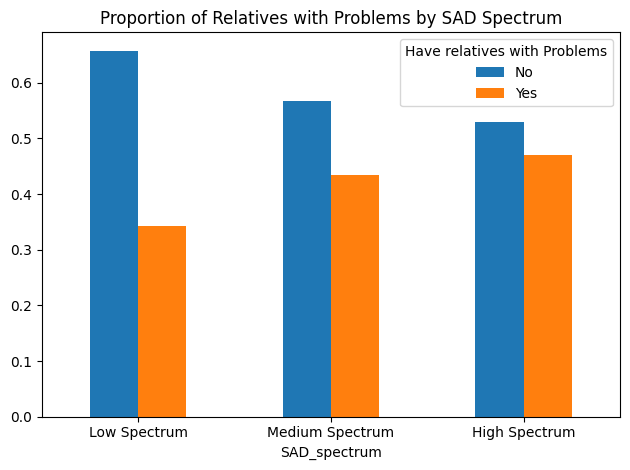

In [33]:
x2_proportions.plot(kind='bar', rot=0)  # rot=0 keeps x-axis labels horizontal
plt.title("Proportion of Relatives with Problems by SAD Spectrum")
plt.legend(title="Have relatives with Problems") #Add a title to the legend
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [34]:
# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(x2_contingency)
print(f"Chi-Square: {chi2:.4f}, p-value: {p: .4g}, DoF: {dof}")

Chi-Square: 34.5566, p-value:  3.134e-08, DoF: 2


In [35]:
# Compute Cramér's V
n = x2_contingency.sum().sum()  # Total sample size
cramers_v = np.sqrt(chi2 / (n * (min(x2_contingency.shape) - 1)))

print(f"Cramér's V: {cramers_v:.4f}")

Cramér's V: 0.0946


## Pearson Correlation

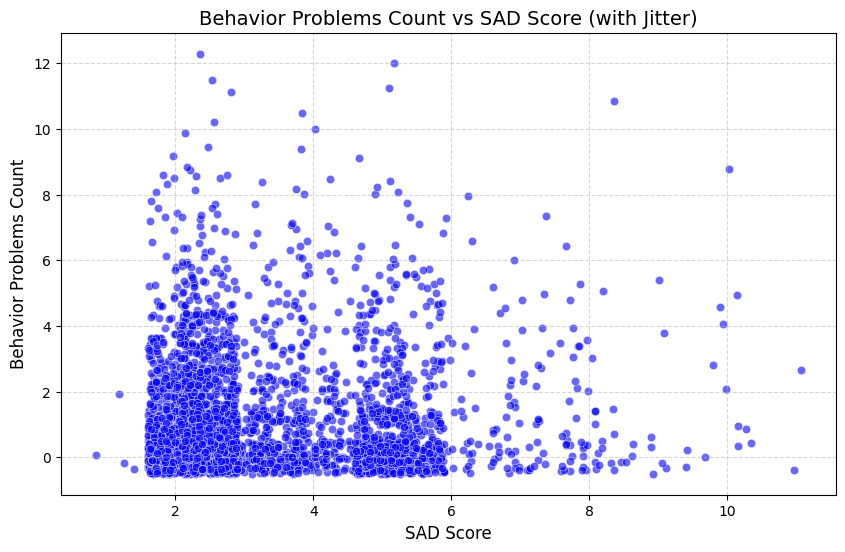

Pearson Correlation Coefficient: 0.0816
P-value: 3.818e-07 ≈ 0.0000
r² = 0.0067


In [36]:
# Compute Pearson correlation
r, p_value = stats.pearsonr(sub2['SAD_score'], sub2['behavior_problems_count'])

#SAD_score and behavior_problems_count scatter plot with jitter
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=sub2['SAD_score'] + np.random.uniform(-0.4, 0.4, size=sub2.shape[0]),  # Add jitter to SAD_score
    y=sub2['behavior_problems_count'] + np.random.uniform(-0.5, 0.5, size=sub2.shape[0]),  # Add jitter to behavior_problems_count
    alpha=0.6, color='blue'
)
plt.title('Behavior Problems Count vs SAD Score (with Jitter)', fontsize=14)
plt.xlabel('SAD Score', fontsize=12)
plt.ylabel('Behavior Problems Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
figures.append(plt.gcf())
plt.show()

print(f'Pearson Correlation Coefficient: {r:.4f}')
print(f'P-value: {p_value:.4g} ≈ {p_value:.4f}')
print('r² = {:.4f}'.format(r**2))

## Moderator variable for ANOVA

Categorize 'SEX' as 'gender' with Male and Female for 1 and 2 values respectively

In [37]:
# Create a new column to categorize sex as 'Male' and 'Female'
sub2['gender'] = sub2['SEX'].map({1: 'Male', 2: 'Female'})

# Make sure 'gender' is a categorical variable
sub2['gender'] = sub2['gender'].astype('category')

In [38]:
# Define the ANOVA model with interaction
moderator_model = smf.ols('behavior_problems_count ~ C(SAD_spectrum) * C(gender)', data=sub2).fit()
moderator_results = sm.stats.anova_lm(moderator_model, typ=2)  # Type 2 ANOVA
moderator_results

,sum_sq,df,F,PR(>F)
C(SAD_spectrum),126.839328,2.0,22.494759,1.937130e-10
C(gender),25.911378,1.0,9.190686,2.448653e-03
C(SAD_spectrum):C(gender),13.520822,2.0,2.397897,9.104440e-02
Residual,10879.711471,3859.0,NaN,NaN
